Sea $(X_k)_{k\geq 0}$ una caminata aleatoria en un círculo. La podemos interpretar como una cadena de Markov con matriz de transición $P$ que toma valores en $E = \{1,2,...,N\}$ y que conecta el primer estado con el último. 

In [1]:
N = 5
p = 0.5

function GenMatrix(N,p)
    P = zeros(N,N)

    #Conectamos los extremos de la caminata aleatoria
    P[N,N-1] = P[1,N] = 1-p
    P[1,2] = P[N,1] = p

    #El resto se define igual
    for i in 2:N-1
        P[i,i+1] = p
        P[i,i-1] = 1-p
    end

    return P
    
end

    
P = GenMatrix(N,p)
    
print(P)

[0.0 0.5 0.0 0.0 0.5; 0.5 0.0 0.5 0.0 0.0; 0.0 0.5 0.0 0.5 0.0; 0.0 0.0 0.5 0.0 0.5; 0.5 0.0 0.0 0.5 0.0]

Programar Wald-Bellman: $V^n(x) = max\{G(x),TV^{n-1}(x)\}$.

Necesitamos:

-Una cadena de Markov (homogénea)

-Una función de ganancia G : E -> R

-Condición sobre la esperanza

Nos enfocamos en $G(x) = \max\{x-k,0\}$ para $k \in N$.

In [2]:
#Función de ganancia
function G(x,k)
    
    return max(x-k,0)
    
end


#Si el espacio de estas E es finito, G se puede ver como un vector
N = length(P[1,:])
k = 2
Gvect = zeros(N)
for i in 1:N
    Gvect[i] = G(i,k)
end

print(Gvect)

[0.0, 0.0, 1.0, 2.0, 3.0]

Para calcular WB usamos la relación $Q^nG = V^n$, donde $QF(x) = \max\{G(x), TF(x)\}$. 

In [3]:
#Operador de traslación (transición), que es tomar esperanza 
#condicional  de F(X_1) partiendo de x
function TrOperator(P,F,x)
    
    n = length(P[1,:])
    E = 0
    for k in 1:n
        E += F[k]*P[x,k]
    end
    
    return E
    
end


#Operador Q
function Qfunc(P,G,F)
    n = length(P[1,:])
    QF = zeros(n)
    for k in 1:n
        QF[k] = max(G[k],TrOperator(P,F,k))
    end
    return QF
end


#Calculamos Wald-Bellman
function Vmax(P,G,N)
        V = G
        for i in 1:N
            V = Qfunc(P,G,V)
        end
        return V
end


print(Vmax(P,Gvect,5))
    

[2.4375, 2.03125, 2.09375, 2.40625, 3.0]

Comparemos distintas iteraciones.

In [4]:
using DataFrames

header2 = []
for i in 1:N
    append!(header2,[string(i)])
end

data = []
for i in 1:N
    if i == 1
        append!(data,[Vmax(P,Gvect,1)])
    else 
        append!(data,[Vmax(P,Gvect,(i-1)*5)])
    end
end

data2 = []
for i in 1:N
    col = zeros(N)
    for j in 1:N
        if j == 1
            v = Vmax(P,Gvect,1)
        else
            v = Vmax(P,Gvect,(j-1)*5)
        end
        col[j] = v[i]
    end
    append!(data2,[col])
end

# Create a DataFrame
df = DataFrame(data2, header2)

# Display the table
println(df)

5×5 DataFrame
 Row │ 1        2        3        4        5       
     │ Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │ 1.5      0.5      1.0      2.0          3.0
   2 │ 2.4375   2.03125  2.09375  2.40625      3.0
   3 │ 2.79297  2.68555  2.66504  2.80566      3.0
   4 │ 2.93265  2.88391  2.89102  2.92825      3.0
   5 │ 2.97513  2.96223  2.95977  2.97666      3.0


Exploramos la relación recursiva de Camargo: $V^n = \max\{V^{n-1},TV^{n-1}\}$. En este caso usamos el operador $\widehat{Q}(F) = \max\{F(x),TF(x)\}$, de modo que $V^n = \widehat{Q}^n(G)$.

In [5]:
#El nuevo operador Q
function QCam(P,F)
    n = length(P[1,:])
    PF = zeros(n)
    for k in 1:n
        PF[k]  = max(F[k],TrOperator(P,F,k))
    end
    return PF
end

#Recursión de Camargo
function VCam(P,G,N)
    V = G
    for i in 1:N
        V = QCam(P,V)
    end
    return V
end
    
    
print("Camargo:")
println(VCam(P,Gvect,1))
print(", WB:")
println(Vmax(P,Gvect,1))
println(" ")
    
for i in 2:5
    print("Camargo:")
    println(VCam(P,Gvect,(i-1)*5))
    print(", WB:")
    println(Vmax(P,Gvect,(i-1)*5))
    println(" ")
end
        


Camargo:[1.5, 0.5, 1.0, 2.0, 3.0]
, WB:[1.5, 0.5, 1.0, 2.0, 3.0]
 
Camargo:[2.4375, 2.03125, 2.09375, 2.40625, 3.0]
, WB:[2.4375, 2.03125, 2.09375, 2.40625, 3.0]
 
Camargo:[2.79296875, 2.685546875, 2.6650390625, 2.8056640625, 3.0]
, WB:[2.79296875, 2.685546875, 2.6650390625, 2.8056640625, 3.0]
 
Camargo:[2.932647705078125, 2.8839111328125, 2.891021728515625, 2.928253173828125, 3.0]
, WB:[2.932647705078125, 2.8839111328125, 2.891021728515625, 2.928253173828125, 3.0]
 
Camargo:[2.97513484954834, 2.9622316360473633, 2.9597673416137695, 2.9766578674316406, 3.0]
, WB:[2.97513484954834, 2.9622316360473633, 2.9597673416137695, 2.9766578674316406, 3.0]
 


Siempre es interesante estudiar algún tipo de noción de tasa de convergencia. Aquí utilizamos $tasa = \lim_{n \to \infty}log(\|u-u_{n+1}\|/\|u-u_{n}\|)$.

In [6]:
#Calcula la norma  1 de la diferencia de la solución real y la solución aproximada
function ErrorFunc(aprox_sol, real_sol)
    K = length(aprox_sol)
    error = 0
    if(length(aprox_sol) == length(real_sol))
        for i in 1:K
            error += abs(aprox_sol[i] - real_sol[i])^2
        end
    end
    return sqrt(error)
end

#Calculamos la tasa de convergencia
function ErrorRateFunc(P,Gvect,real_sol, n)
    error_rates = zeros(n) 
    error_rates[1] = 1
    aprox_sols = zeros(2,length(real_sol))
    for i in 2:n
        aprox_sols[1,:] = Vmax(P,Gvect,i-1)
        aprox_sols[2,:] = Vmax(P,Gvect,i)
        error_rates[i] = log(ErrorFunc(aprox_sols[2,:],real_sol)/ErrorFunc(aprox_sols[1,:],real_sol))/log(0.5)
    end
    return error_rates
    
end


real_sol = zeros(N)
for i in 1:N
    
    real_sol[i] = Gvect[N]

end


error_rate = ErrorRateFunc(P,Gvect,real_sol, 10)
print(error_rate)

[1.0, 0.31797321471998063, 0.3075576673638784, 0.3060210173887202, 0.305796455500702, 0.30576368452080516, 0.30575890313229964, 0.30575820553356364, 0.30575810375520407, 0.3057580889059397]

¿Qué pasa si la cadena de Markov tiene un estado absorbente?

In [7]:
#Matriz de transición
P = [1 0 0; 0.1 0.2 0.7 ; 0.3 0.6 0.1]

#Discretización de la función de ganancia
k = 2
N = length(P[1,:])
Gvect = zeros(N)
for i in 1:N
    Gvect[i] = G(i,k)
end

print(VCam(P,Gvect,50))

[0.0, 0.875, 1.0]

¿Qué pasa si matamos la cadena de Markov en un tiempo geométrico?

In [8]:
N = 5

P = GenMatrix(N,p)

P[1,:] = zeros(N)
P[1,1] = 1

Gvect = zeros(N)
for i in 1:N
    Gvect[i] = G(i,k)
end

using DataFrames

header2 = []
for i in 1:N
    append!(header2,[string(i)])
end

data = []
for i in 1:N
    if i == 1
        append!(data,[Vmax(P,Gvect,1)])
    else 
        append!(data,[Vmax(P,Gvect,(i-1)*5)])
    end
end

data2 = []
for i in 1:N
    col = zeros(N)
    for j in 1:N
        if j == 1
            v = Vmax(P,Gvect,1)
        else
            v = Vmax(P,Gvect,(j-1)*5)
        end
        col[j] = v[i]
    end
    append!(data2,[col])
end

df = DataFrame(data2, header2)

println(df)

5×5 DataFrame
 Row │ 1        2         3        4        5       
     │ Float64  Float64   Float64  Float64  Float64 
─────┼──────────────────────────────────────────────
   1 │     0.0  0.5       1.0      2.0          3.0
   2 │     0.0  0.6875    1.375    2.1875       3.0
   3 │     0.0  0.734375  1.48438  2.23438      3.0
   4 │     0.0  0.748047  1.49609  2.24805      3.0
   5 │     0.0  0.749512  1.49951  2.24951      3.0


Segunda interpretación.

In [10]:
using Distributions
using DataFrames


N = 5
p = 0.5                     #Parámetro de la caminata
q = 0.2                     #Parámetro de las variables  geométricas
P = GenMatrix(N,p)

Pdeath = zeros(N+1,N+1)


Pdeath[1,1] = 1

for i in 2:N+1
    Pdeath[i,1] = 1-q
    for j in 2:N+1
        Pdeath[i,j] = q*P[i-1,j-1]
    end
end

k = 2
Gvect2 = zeros(N+1)
Gvect2[1] = 0
for i in 2:N+1
    Gvect2[i] = G(i-1,k)
end

N = N+1
header2 = []
for i in 1:N
    append!(header2,[string(i)])
end

data = []
for i in 1:N
    if i == 1
        append!(data,[Vmax(Pdeath,Gvect2,1)])
    else 
        append!(data,[Vmax(Pdeath,Gvect2,(i-1)*5)])
    end
end

data2 = []
for i in 1:N
    col = zeros(N)
    for j in 1:N
        if j == 1
            v = Vmax(Pdeath,Gvect2,1)
        else
            v = Vmax(Pdeath,Gvect2,(j-1)*5)
        end
        col[j] = v[i]
    end
    append!(data2,[col])
end

df = DataFrame(data2, header2)

println(df)

6×6 DataFrame
 Row │ 1        2         3         4        5        6       
     │ Float64  Float64   Float64   Float64  Float64  Float64 
─────┼────────────────────────────────────────────────────────
   1 │     0.0  0.3       0.1           1.0      2.0      3.0
   2 │     0.0  0.31313   0.13131       1.0      2.0      3.0
   3 │     0.0  0.313131  0.131313      1.0      2.0      3.0
   4 │     0.0  0.313131  0.131313      1.0      2.0      3.0
   5 │     0.0  0.313131  0.131313      1.0      2.0      3.0
   6 │     0.0  0.313131  0.131313      1.0      2.0      3.0


¿Qué pasa si matamos la cadena de Markov al salir de una región?

In [11]:
N = 10                    
p = 0.5                  
lim = 6                   
P = GenMatrix(N,p)        

Pdeath = zeros(N+1,N+1)
Pdeath[1,1] = 1

for i in 2:N+1
    if i<=lim+1
        Pdeath[i,2:N+1] = P[i-1,:]
    else
        Pdeath[i,1] = 1
    end
end


k = 4
Gvect2 = zeros(N+1)
Gvect2[1] = 0
for i in 2:N+1
    Gvect2[i] = G(i-1,k)
end

Pdeath
#println(VCam(Pdeath,Gvect2,100))

11×11 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5
 0.0  0.5  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

Caso submarkoviano

In [19]:
N = 5
p = 0.5                     #Parámetro de la caminata
q = 0.2                     #Parámetro de las variables  geométricas
P = GenMatrix(N,p)

Pdeath = zeros(N+1,N+1)


Pdeath[1,1] = 1

for i in 2:N+1
    Pdeath[i,1] = 1-q
    for j in 2:N+1
        Pdeath[i,j] = q*P[i-1,j-1]
    end
end


Psub = zeros(N,N)

for i in 1:N
    for j in 1:N
        Psub[i,j] = Pdeath[i+1,j+1]
    end
end

Gvect = zeros(N)
for i in 1:N
    Gvect[i] = G(i,k)
end

Gvect2 = zeros(N+1)
Gvect2[1] = 0
for i in 2:N+1
    Gvect2[i] = G(i-1,k)
end

println(VCam(Psub,Gvect,5))
println(VCam(Pdeath,Gvect2,5))
#print(Psub)


[0.31313, 0.13131, 1.0, 2.0, 3.0]
[0.0, 0.31313, 0.13131, 1.0, 2.0, 3.0]


In [22]:
#Matriz de transición
P = [0 0.3 0.5 ; 0 0.2 0.7 ; 0 0.6 0.1]

#Discretización de la función de ganancia
k = 2
N = length(P[1,:])
Gvect = zeros(N)
for i in 1:N
    Gvect[i] = G(i,k)
end

print(VCam(P,Gvect,100))

[0.7625, 0.875, 1.0]

Representación gráfica

[1.0, 10.0, 9.0, 10.0, 9.0, 10.0, 9.0, 8.0, 7.0, 8.0, 9.0, 10.0, 1.0, 10.0, 9.0, 10.0, 9.0, 10.0, 1.0, 10.0, 1.0, 2.0, 1.0, 10.0, 1.0, 10.0, 9.0, 8.0, 7.0, 6.0, 7.0, 6.0, 7.0, 8.0, 9.0, 10.0, 9.0, 8.0, 9.0, 10.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 4.0, 3.0]


[ Info: Saved animation to C:\Users\jonan\anim_fps15.gif


Plots.AnimatedGif("C:\\Users\\jonan\\anim_fps15.gif")
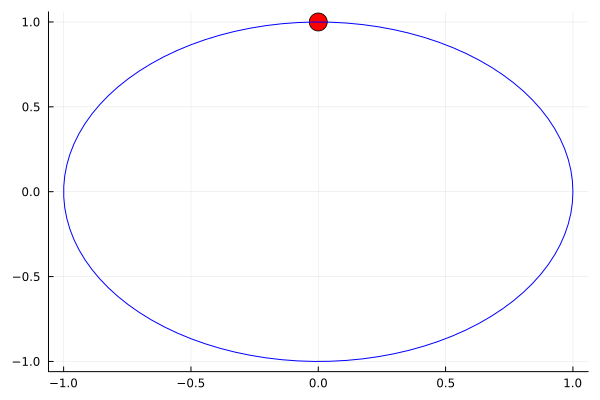

In [18]:
using Distributions
using Plots

function MarkovSequence(P,M,p,s)
    
    n = length(P[1,:])
    freq_vec = zeros(M+1)
    freq_vec[1] = s
    RowTransMatrix = P[s,:]
    
    for i in 1:M
        px = rand(Uniform(0,1))
        if (px < p)
            if s<n
                s = s+1
                freq_vec[i+1] = s
                RowTransMatrix = P[s,:]
            elseif (s == n)
                s = 1
                freq_vec[i+1] = 1 
                RowTransMatrix = P[1,:]
            end
                    
        else 
            if 1<s
                s = s-1
                freq_vec[i+1] = s
                RowTransMatrix = P[s,:]
            elseif (s == 1)
                s = n
                freq_vec[i+1] = n 
                RowTransMatrix = P[n,:]
            end
            
        end


    end

    return freq_vec
    
    
end

M = 50
N = 10
P = GenMatrix(N,p)
p= 0.5
sequence = MarkovSequence(P,M,p,1)

n = length(P[1,:])
delta = 2*pi/n
sequence_arg = zeros(M+1)
sequence_arg[1] = pi/2
for i in 1:M
    if abs(sequence[i+1]-sequence[i]) == 1
        sequence_arg[i+1] = sequence_arg[i] + (-sequence[i+1]+sequence[i])*delta
    elseif (sequence[i+1]-sequence[i])<-1
        sequence_arg[i+1] = pi/2 
    elseif (sequence[i+1]-sequence[i])>1
        sequence_arg[i+1] = pi/2 + delta
    end
        
end

theta = range(0, 2π, length = 100)


x_circle = cos.(theta)
y_circle = sin.(theta)
plot!(theta, zeros(100), color = :blue, label = "")
plot!(x_circle, y_circle, color = :blue, label = "")
#plot(plot1, plot2, layout=(1,2), legend=true)
x = cos.(sequence_arg)
y = sin.(sequence_arg)

println(sequence)

anim = @animate for i ∈ 1:M
    scatter([x[i]], [y[i]], color = :red, markersize = 10, label = "")
    plot!(x_circle, y_circle, color = :blue, label = "")
end
gif(anim, "anim_fps15.gif", fps = 2)